In [ ]:
!pip install yfinance
!pip install numpy_financial

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import numpy_financial as npf

In [30]:
# ^SP500TR
# FTSEMIB.MI
# GC=F
# BTC-USD
df=yf.download("^SP500TR",start="1980-1-1")["Adj Close"]
idx = pd.date_range(df.index[0], df.index[-1])
df.index = pd.DatetimeIndex(df.index)
df = df.reindex(idx, method="ffill")

[*********************100%***********************]  1 of 1 completed


In [31]:
df

2000-08-30     273.899994
2000-08-31     278.299988
2000-09-01     277.000000
2000-09-02     277.000000
2000-09-03     277.000000
                 ...     
2023-11-30    2038.099976
2023-12-01    2071.000000
2023-12-02    2071.000000
2023-12-03    2071.000000
2023-12-04    2046.300049
Freq: D, Name: Adj Close, Length: 8497, dtype: float64

<Axes: >

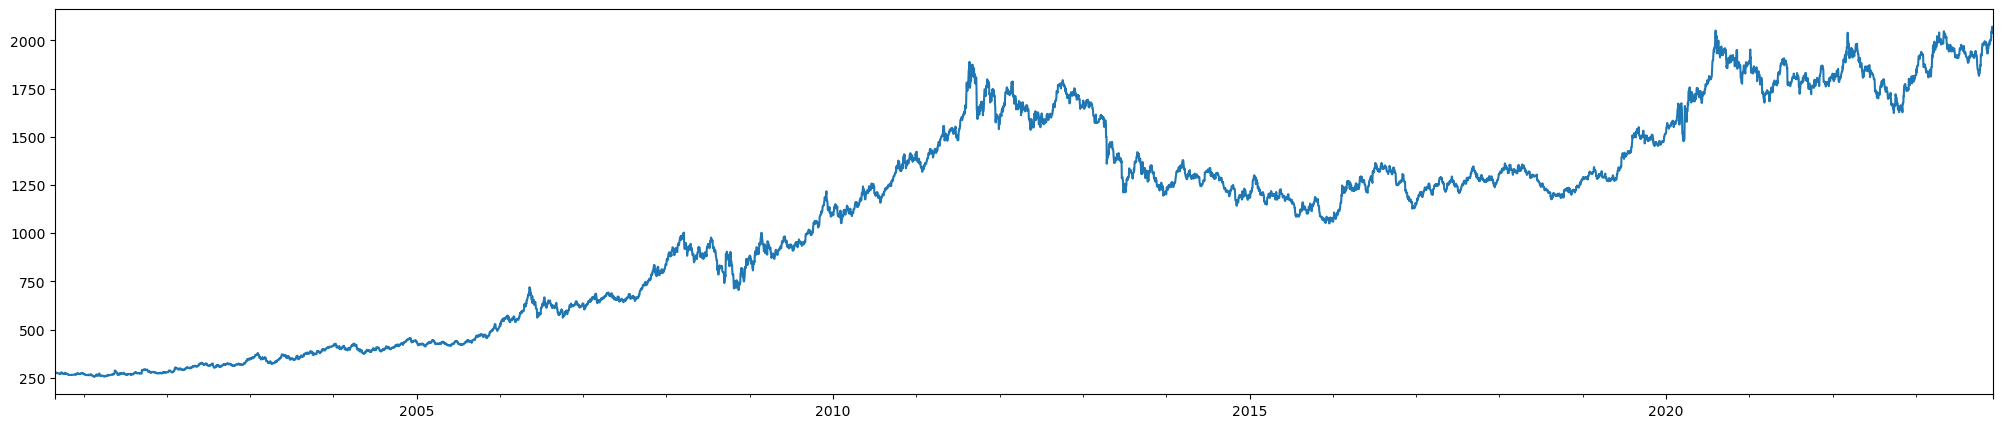

In [39]:
df.plot(figsize=(25,5))

In [32]:
# df.to_excel("dati.xlsx")

## Parametri

In [33]:
anni = 7
investimentoMensile = 100
interesseAnnuo = 0.03
incrementoAnnuo = 0.05

interesseMensile = (1+interesseAnnuo)**(30/365)-1
incrementoMensile = (1+incrementoAnnuo)**(30/365)-1
oggi = datetime.date.today()
oggi10annifa = oggi - relativedelta(days=360*anni)
print(oggi10annifa)

2017-01-09


## Conti

In [34]:
date = []
ricavi = [[],[],[]]
for inizio in df.loc[:oggi10annifa].index: # esegue il loop su tutte le possibili date iniziali fino a 10 anni fa
    fine = inizio + relativedelta(days=360*anni)
    
    SoldiDainvestire = []
    for riga in range(1,anni*12+3):  # +1 per le paranoie di Python, +2 perché ci saranno casini con i mesi di bordo
        SoldiDainvestire.append(investimentoMensile * (1+incrementoMensile)**(riga-1))

    QuoteDCAtotali = 0.0
    QuoteVAtotali = 0.0
    QuoteVAPtotali = 0.0
    BuffertotaleVA = 0.0
    BuffertotaleVAP = 0.0
    ValoreVAtarget = 0.0
    ValoreVAPtarget = 0.0

    riga = 1
    for giorno in df.loc[inizio:fine].resample("30D").first().index:
        Prezzo = df.loc[giorno]
      
        QuoteDCAfinora = QuoteDCAtotali
        QuoteDCAdacomprare = SoldiDainvestire[riga] / Prezzo
        SpesoDCA = QuoteDCAdacomprare * Prezzo
        QuoteDCAtotali = QuoteDCAfinora + QuoteDCAdacomprare
        ValoreDCAtotale = QuoteDCAtotali * Prezzo
        
        ValoreVAtarget = ValoreVAtarget + investimentoMensile*(1+incrementoMensile)**(riga-1)
        QuoteVAfinora = QuoteVAtotali
        ValoreVAfinora = QuoteVAfinora * Prezzo
        SoldiVAcheinvestiro = ValoreVAtarget - ValoreVAfinora
        QuoteVAdacomprare = SoldiVAcheinvestiro / Prezzo
        SpesoVA = QuoteVAdacomprare * Prezzo
        QuoteVAtotali = QuoteVAfinora + QuoteVAdacomprare
        ValoreVAtotale = QuoteVAtotali * Prezzo
        DeltaVA = SoldiDainvestire[riga] - SpesoVA
        BufferVA = BuffertotaleVA + DeltaVA
        InteressiVA = BufferVA * interesseMensile
        BuffertotaleVA = BufferVA + InteressiVA
        
        ValoreVAPtarget = ValoreVAPtarget + investimentoMensile*(1+incrementoMensile)**(riga-1)
        QuoteVAPfinora = QuoteVAPtotali
        ValoreVAPfinora = QuoteVAPfinora * Prezzo
        SoldiVAPcheinvestirei = ValoreVAPtarget - ValoreVAPfinora
        QuoteVAPdacomprare = max( 0, min( SoldiVAPcheinvestirei , SoldiDainvestire[riga] + BuffertotaleVAP ) ) / Prezzo
        SpesoVAP = QuoteVAPdacomprare * Prezzo
        QuoteVAPtotali = QuoteVAPfinora + QuoteVAPdacomprare
        ValoreVAPtotale = QuoteVAPtotali * Prezzo
        DeltaVAP = SoldiDainvestire[riga] - SpesoVAP
        BufferVAP = BuffertotaleVAP + DeltaVAP
        InteressiVAP = BufferVAP * interesseMensile
        BuffertotaleVAP = BufferVAP + InteressiVAP
        
        riga = riga +1
        
    date.append(inizio)
    ricavi[0].append( ValoreDCAtotale )
    ricavi[1].append( ValoreVAtotale + BufferVA )
    ricavi[2].append( ValoreVAPtotale + BufferVAP )
  

## Risultati

<Axes: ylabel='Frequency'>

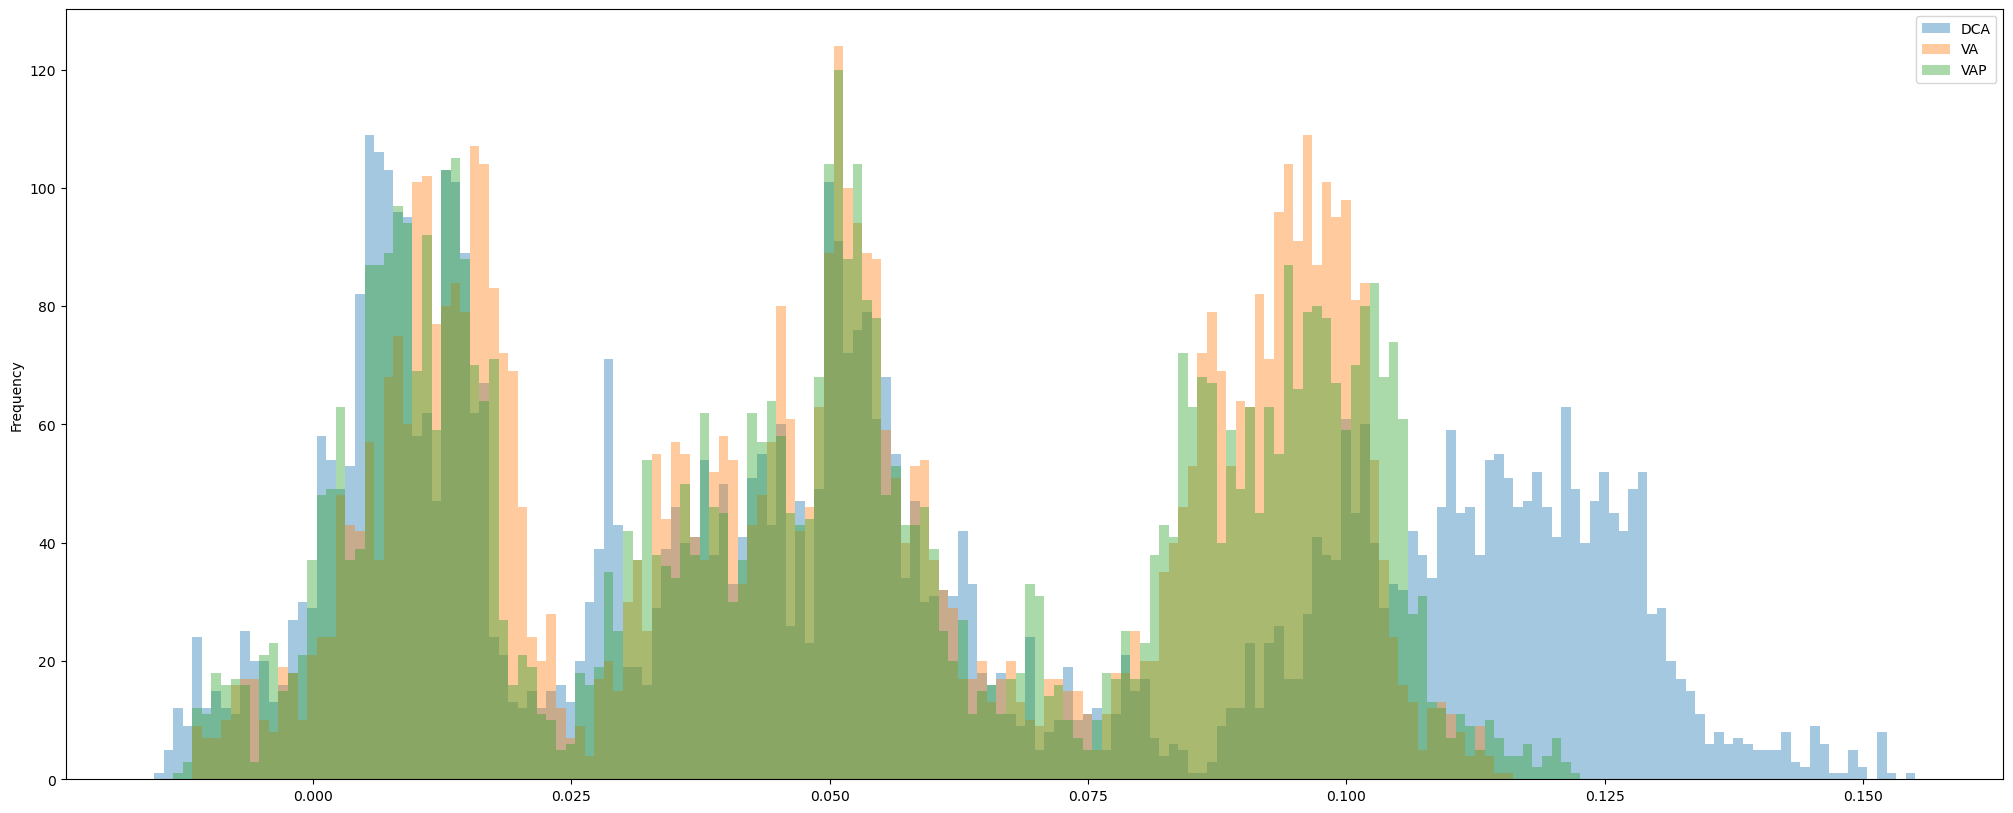

In [35]:
risultati = pd.DataFrame(ricavi,columns=date,index=["DCA","VA","VAP"]).transpose()
investito = npf.npv(interesseMensile,SoldiDainvestire)
rendimento = (risultati/investito)**(1/anni)-1
rendimento.plot(kind="hist",figsize=(25,10),bins=int((len(df)-360*anni)**0.6),alpha=0.4)

In [36]:
rendimento.describe()

DCA           VA          VAP
count  5977.000000  5977.000000  5977.000000
mean      0.058208     0.052759     0.052072
std       0.044544     0.034105     0.035532
min      -0.015395    -0.011615    -0.013251
25%       0.014607     0.018442     0.015883
50%       0.050991     0.051013     0.050563
75%       0.103037     0.088265     0.087324
max       0.155051     0.115699     0.122113